In [27]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from glob import glob

In [ ]:
clean_folder_path = r"C:\Users\91909\Desktop\ML\DATA\NTIRE\clean_data\DIV2K\DIV2K_train_HR\DIV2K_train_HR"
noisy_folder_path = r"C:\Users\91909\Desktop\ML\DATA\NTIRE\noisy_data\DIV2K\DIV2K_train_HR\DIV2K_train_HR"

test_folder_path = r"C:\Users\91909\Desktop\ML\DATA\NTIRE\clean_data\DIV2K\noise\noise"
save_folder_path = r"C:\Users\91909\Desktop\ML\DATA\NTIRE\clean_data\DIV2K\noise\noise_cleaned_test"

In [29]:
PATCH_SIZE = 128

In [30]:
def load_image(filename):
    img = cv2.imread(filename, cv2.IMREAD_COLOR)
    img = img.astype('float32') / 255.0
    return img

In [31]:
def extract_patches(image, patch_size=PATCH_SIZE):
    h, w, _ = image.shape
    patches, positions = [], []
    
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = image[i:i+patch_size, j:j+patch_size]
            if patch.shape[0] == patch_size and patch.shape[1] == patch_size:
                patches.append(patch)
                positions.append((i, j))
            else:
                pad_patch = np.zeros((patch_size, patch_size, 3), dtype=np.float32)
                pad_patch[:patch.shape[0], :patch.shape[1]] = patch
                patches.append(pad_patch)
                positions.append((i, j))
    
    return np.array(patches), positions, (h, w)

In [32]:
def stitch_patches(patches, positions, image_size):
    h, w = image_size
    stitched_image = np.zeros((h, w, 3), dtype=np.float32)
    count_map = np.zeros((h, w, 3), dtype=np.float32)
    
    for patch, (i, j) in zip(patches, positions):
        stitched_image[i:i+PATCH_SIZE, j:j+PATCH_SIZE] += patch
        count_map[i:i+PATCH_SIZE, j:j+PATCH_SIZE] += 1
    
    stitched_image /= np.maximum(count_map, 1)
    return (stitched_image * 255).astype(np.uint8)

In [33]:
def build_denoising_model(input_shape=(PATCH_SIZE, PATCH_SIZE, 3)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)
    model = keras.Model(inputs, x)
    model.compile(optimizer='adam', loss='mse')
    return model

In [34]:
model = build_denoising_model()

In [35]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 128, 128, 3)      1731      
 ranspose)                                                       
                                                                 
Total params: 40,451
Trainable params: 40,451
Non-trainable params: 0
_________________________________________________________________


In [36]:
def data_generator(clean_folder, noisy_folder, batch_size=8):
    datagen = ImageDataGenerator()
    clean_gen = datagen.flow_from_directory(clean_folder, target_size=(PATCH_SIZE, PATCH_SIZE), batch_size=batch_size, class_mode=None)
    noisy_gen = datagen.flow_from_directory(noisy_folder, target_size=(PATCH_SIZE, PATCH_SIZE), batch_size=batch_size, class_mode=None)
    
    while True:
        clean_batch = next(clean_gen)
        noisy_batch = next(noisy_gen)
        yield noisy_batch, clean_batch

In [37]:
import matplotlib.pyplot as plt
def printplot(history):
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history["accuracy"], color="red", label="train")
        plt.plot(history.history["val_accuracy"], color="blue", label="validation")
        plt.title("Graph of accuracy over epochs")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history["loss"], color="red", label="train")
        plt.plot(history.history["val_loss"], color="blue", label="validation")
        plt.title("Graph of loss over epochs")
        plt.legend()

In [38]:
def train_model(clean_folder, noisy_folder, epochs=10, batch_size=8):
    train_data = data_generator(clean_folder, noisy_folder, batch_size)
    steps_per_epoch = len(glob(os.path.join(clean_folder, '*'))) // batch_size
    history = model.fit(train_data, steps_per_epoch=steps_per_epoch, epochs=epochs)
    printplot(history)
    model.save('denoising_model.h5')
    return model

In [39]:
def predict_images(model, noisy_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    noisy_images = glob(os.path.join(noisy_folder, '*'))
    
    for idx, filename in enumerate(noisy_images):
        img = load_image(filename)
        patches, positions, img_size = extract_patches(img)
        denoised_patches = model.predict(patches)
        denoised_img = stitch_patches(denoised_patches, positions, img_size)
        
        cv2.imwrite(os.path.join(output_folder, f'denoised_{idx}.png'), denoised_img)

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Epoch 1/20
100/100 [==============================] - 1s 6ms/step - loss: 0.0000e+00
Epoch 2/20
100/100 [==============================] - 1s 5ms/step - loss: 0.0000e+00
Epoch 3/20
100/100 [==============================] - 1s 6ms/step - loss: 0.0000e+00
Epoch 4/20
100/100 [==============================] - 1s 6ms/step - loss: 0.0000e+00
Epoch 5/20
100/100 [==============================] - 1s 5ms/step - loss: 0.0000e+00
Epoch 6/20
100/100 [==============================] - 1s 7ms/step - loss: 0.0000e+00
Epoch 7/20
100/100 [==============================] - 1s 6ms/step - loss: 0.0000e+00
Epoch 8/20
100/100 [==============================] - 1s 6ms/step - loss: 0.0000e+00
Epoch 9/20
100/100 [==============================] - 1s 5ms/step - loss: 0.0000e+00
Epoch 10/20
100/100 [==============================] - 1s 6ms/step - loss: 0.0000e+00
Epoch 11/20
100/100 [==============================] - 0s 5ms/step - lo

KeyError: 'accuracy'

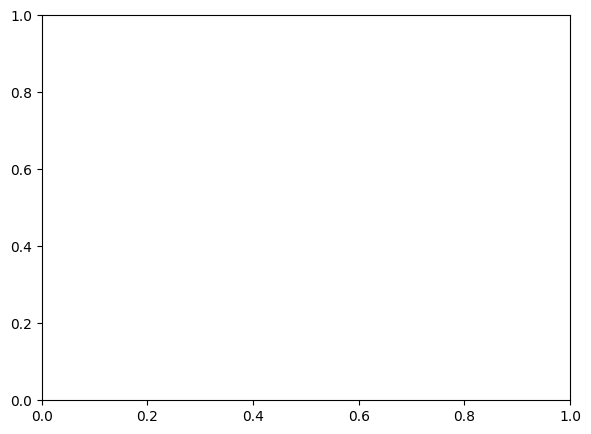

In [40]:
train_model(clean_folder_path, noisy_folder_path, epochs=20, batch_size=8)

In [41]:
predict_images(model, r"C:\Users\91909\Desktop\ML\DATA\NTIRE\clean_data\DIV2K\noise\noise",r"C:\Users\91909\Desktop\ML\DATA\NTIRE\clean_data\DIV2K\noise\noise_cleaned_test")

6/6 [==============================] - 9s 140ms/step


ValueError: operands could not be broadcast together with shapes (128,120,3) (128,128,3) (128,120,3) 